In [1]:
# All dependencies
import sys
import requests
import numpy as np
import pandas as pd
import numpy.linalg as la
import matplotlib.pyplot as plt

from os import path
from time import time
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D as plt3

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler as SS
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.inspection import permutation_importance as perm_imp
from sklearn.model_selection import train_test_split as tts, cross_validate, GridSearchCV as GSCV

# important global constants
global default_data_percentage
default_data_percentage = 1

**Commonly Used Methods**

The methods below are commonly used when running a variety of classification and regression models.

**Culling the Accidents Data**

In the `accidents.csv` file, we found that there was too much data accidents of severity 2 and three recorded, leading to nearly unreadable graphs and an unusually high accuracy.  As a result, a method was created to ensure the number of all accidents was roughly even across all severities.

In [8]:
def plot_ftrs(X, y, dimensions=2, cmap="viridis"):
    components = PCA(n_components=(dimensions)).fit(X).transform(X)
    if dimensions == 2:
        fig = plt.figure().add_subplot(111)
        scatter = fig.scatter(components[:, 0], components[:, 1], c=y, cmap=cmap)
    else:
        fig = plt.figure().add_subplot(111, projection="3d")
        scatter = fig.scatter(components[:, 0], components[:, 1], components[:, 2], c=y, cmap=cmap)
    
    plt.colorbar(scatter, ax=fig, ticks=list(np.unique(y)))
    plt.show()

def dataframe_from_csv(file_name, exclude_cols):
    cols = list(pd.read_csv(f"{file_name}.csv", nrows=1))

    return pd.read_csv(f"{file_name}.csv", usecols=[a for a in cols if a not in exclude_cols])

def get_accuracy(y_test, y_pred, use_np_mean=False):
    if use_np_mean:
        accuracy = np.mean(y_test == y_pred)
    else:
        accuracy = np.dot(y_test, y_pred) / (la.norm(y_test) * la.norm(y_pred))
    
    return float(f"{accuracy * 100:.3f}")

def get_mean_absolute_error(y, y_pred):
    return np.mean(np.absolute(np.asarray(y) - np.asarray(y_pred)))

def cull_data(frame_key, features, percent_of_even_data_to_use=default_data_percentage,
              exclude_labels=None):
    copied_dataset = data_frames[frame_key][features].dropna().values.copy()
    if exclude_labels is not None:
        for label in exclude_labels:
            copied_dataset = copied_dataset[copied_dataset[:, -1] != label]

    np.random.shuffle(copied_dataset)
    
    unique_labels, unique_label_counts = np.unique(dataset[:, -1], return_counts=True)
    returning_dataset = copied_dataset[copied_dataset[:, -1] == unique_labels[0]][:int(np.min(unique_label_counts) * percent_of_even_data_to_use), :]
    for l in range(1, len(unique_labels)):
        returning_dataset = np.vstack((returning_dataset, copied_dataset[copied_dataset[:, -1] == unique_labels[l]][:int(np.min(unique_label_counts) * percent_of_even_data_to_use), :]))
    
    np.random.shuffle(returning_dataset)
    return returning_dataset

def mult_list(val_list):
    product = len(val_list[0])

    for val in val_list:
        product *= len(val_list)

    return product

def count_iters(params):
    param_lens = [len(val) for _, val in params.items()]
    return sum(param_lens) + mult_list(param_lens)
    

def custom_cv(estimators, X, y, params_list, scoring = 'accuracy', test_size=0.3, seed=42, timed=True, verbose=False):
    if timed: start_time = time()

    ret_dict = {}
    X_train, X_test, y_train, y_test = tts(X, y, test_size=test_size, random_state=seed)

    if len(estimators) != len(params_list):
        print("The number of estimators and corresponding parameters does not match")
        return
        
    for a in range(len(estimators)):
        estimator_name = estimators[a].__class__.__name__
        if timed: individual_time = time()
        pipe = Pipeline([("scaler", SS()), ("gscv", GSCV(estimators[a], params_list[a], scoring = scoring, verbose=1 if verbose else 0))])
        pipe.fit(X_train, y_train)
        
        if scoring == 'neg_mean_absolute_error':
            ret_dict[estimator_name] = {
                "best_mae": get_mean_absolute_error(y_test, pipe.predict(X_test)),
                "best_estimator": pipe.named_steps["gscv"].best_estimator_,
                "best_params": pipe.named_steps["gscv"].best_params_,
                "best_score": pipe.named_steps["gscv"].best_score_,
            }
        else:
            ret_dict[estimator_name] = {
                "best_accuracy": get_accuracy(y_test, pipe.predict(X_test)),
                "best_estimator": pipe.named_steps["gscv"].best_estimator_,
                "best_params": pipe.named_steps["gscv"].best_params_,
                "best_score": pipe.named_steps["gscv"].best_score_,
            }

        if estimator_name == "SVC":
            try:
                ret_dict[estimator_name]["feature_importances"] = pipe.named_steps["gscv"].best_estimator_.coef_ / pipe.named_steps["scaler"].scale_
            except AttributeError:  # Only valid for linear kernel
                importance = perm_imp(ret_dict[estimator_name]["best_estimator"], X_test, y_test, n_repeats=30, random_state=seed)
                ret_dict[estimator_name]["feature_importances"] = importance.importances_mean.argsort()
        if estimator_name == "RandomForestClassifier":
            ret_dict[estimator_name]["feature_importances"] = pipe.named_steps["gscv"].best_estimator_.feature_importances_

        if timed: ret_dict[estimator_name]["fit_time"] = time() - individual_time
        if verbose and timed: print(f"{estimator_name} fit time: {ret_dict[estimator_name]['fit_time']:.3f} seconds")

    if timed: ret_dict["total_time"] = time() - start_time
    if verbose and timed: print(f"Total Cross Validation fit time: {ret_dict['total_time'] / 60:.3f} minutes\n")

    return ret_dict

def print_cv_results(cust_cv_results, precision=3, problem_type = "classification"):
    for key, results_dict in cust_cv_results.items():
        if not isinstance(results_dict, dict) or key == "dataset":
            continue

        # print(f"Dict: {key}, Keys: {results_dict.keys()}")
        print(f"Showing results of Grid Search and Cross Validation for: {key}")
        print(f"\tBest Params: {results_dict['best_params']}")
        print(f"\tBest Score: {results_dict['best_score']:.{precision}f}")
        if problem_type == "regression":
            print(f"\tFinal {key} Mean Absolute Error: {results_dict['best_mae']:.{precision}f}")
        else:
            print(f"\tFinal {key} Accuracy: {results_dict['best_accuracy']:.{precision}f}%")
        try:
            print(f"\t{key} Fit Time: {results_dict['fit_time']:.{precision}f} seconds\n")
        except KeyError:
            print()

    try:
        print(f"Total time to fit all classifiers: {cust_cv_results['total_time'] / 60:.{precision}f} minutes")
    except KeyError:
        pass

**Downloading of the Data Files**

We used dropbox to store the CSV files and used their urls to load them into pandas Dataframes using our custom method `dataframe_from_csv`.
To save load time, if the method first checks if the datasets are already downloading before attempting to download from the dropbox.

In [3]:
# Download data files
def load_datasets(combined=False):
    urls = {
        "vehicles": "https://www.dropbox.com/scl/fi/rfywugpl0vxo5mc5b7uy7/Vehicles0514.csv?rlkey=v4yygd6hc96ejfm9nt1fvadz9&dl=0",
        "casualties": "https://www.dropbox.com/scl/fi/o1ljw70bzrwmx0x8etifq/Casualties0514.csv?rlkey=iwyg1ergtazhl6mgwqk78xn5s&dl=0",
        "accidents": "https://www.dropbox.com/scl/fi/7enn6tyaavc8ch8hlib0f/Accidents0514.csv?rlkey=u316i9rln87722m1fefzfp5ba&dl=0",
        "data-guide": "https://www.dropbox.com/scl/fi/amogx0ugusmivneq6ardz/Road-Accident-Safety-Data-Guide.xls?rlkey=rnkxrf6eqjer67x2lv99tzvvv&dl=0"
    }

    ret_frames = {}

    exclude_columns = ["Accident_Index", "LSOA_of_Accident_Location"]
    valid_datasets = list(urls.keys())[:-1]
    for file_name in valid_datasets:
        print(f"Loading {file_name}.csv")
        if path.exists(f"{file_name}.csv"):
            ret_frames[file_name] = dataframe_from_csv(file_name, exclude_columns)
            continue
        
        direct_url = urls[file_name].replace("&dl=0", "&dl=1")
        response = requests.get(direct_url)

        with open(f"{file_name}.csv", "wb") as f:
            f.write(response.content)
            print(f"Wrote {file_name}.csv")

        ret_frames[file_name] = dataframe_from_csv(file_name, exclude_columns)

    if combined:
        print("Creating combined table")
        ret_frames["combination"] = pd.concat([ret_frames[name] for name in valid_datasets], axis=1)
        ret_frames["combination"] = ret_frames["combination"].loc[:, ~ret_frames["combination"].columns.duplicated()]

    return ret_frames

data_frames = load_datasets(combined=True)
print("Done!")

Loading vehicles.csv
Loading casualties.csv
Loading accidents.csv
Creating combined table
Done!


## Method
We approached testing each classifier for all classification problems by using Grid Search combined with Cross Validation on our culled dataset to obtain the best parameters for each classifier.

In [4]:
def run_classifier_models(frame_key, features=None, percent_of_even_data_to_use=None,
                          exclude_labels=None, plot_ftrs=False):
    if percent_of_even_data_to_use is None:
        dataset = cull_data(frame_key, features=features, exclude_labels=exclude_labels)
    else:
        dataset = cull_data(
            frame_key,
            features=features,
            percent_of_even_data_to_use=percent_of_even_data_to_use,
            exclude_labels=exclude_labels
        )

    print(f"Culled label counts:\n{np.unique(dataset[:, -1], return_counts=True)}")

    X = dataset[:, :-1]
    y = dataset[:, -1]
    
    if plot_ftrs: plot_ftrs(X, y, dimensions=2)
    
    svc_params = {
        "kernel": ["linear", "rbf"],
        "C": [0.001, 0.01, 0.1, 1, 10],
        "gamma": [0.001, 0.01, 0.1, 1, 10],
    }
    rfc_params = {
        "n_estimators": [1, 10, 100, 1000]
    }
    knn_params = {
        "n_neighbors": [1, 2, 4, 8, 10, 20, 40, 80]
    }

    results = custom_cv([SVC(), RFC(), KNN()], X, y, params_list=[svc_params, rfc_params, knn_params], scoring = 'accuracy', verbose=True)
    results["dataset"] = {
        "frame_key": frame_key,
        "exclude_labels": exclude_labels,
        "X": X,
        "y": y,
    }
    print_cv_results(results, precision=4)
    return results

def create_feature_pair_plot(accident_data, feature_names, labels, index_of_first_feature, index_of_second_feature):
    plt.scatter(accident_data[:, index_of_first_feature], accident_data[:, index_of_second_feature], c=labels, cmap="viridis", alpha=0.75)
    plt.xlabel(feature_names[index_of_first_feature])
    plt.ylabel(feature_names[index_of_second_feature])
    plt.show()

def print_label_counts(dataset):
    labels, counts = np.unique(dataset[:, -1], return_counts=True)
    for label, count in zip(labels, counts):
        print(f"Label: {label}, Count: {count}")

def collect_top_features(num_of_top_feature_to_return, feature_names, feature_weights):
    if num_of_top_feature_to_return >= len(feature_names):
        return
    
    top_feature_names = np.array([])
    top_feature_weights = np.array([])
    for f in range(0, num_of_top_feature_to_return):
        most_important_feature_index = feature_weights.argmax()
        top_feature_names = np.append(top_feature_names, feature_names[most_important_feature_index])
        top_feature_weights = np.append(top_feature_weights, feature_weights[most_important_feature_index])
        feature_names = np.delete(feature_names, most_important_feature_index)
        feature_weights = np.delete(feature_weights, most_important_feature_index)
    return top_feature_names, top_feature_weights


In [32]:
# First Question: How does the weather impact the serverity of the accident?
feature_names = ["Weather_Conditions", "Road_Surface_Conditions", "Special_Conditions_at_Site", "Carriageway_Hazards", "Accident_Severity"]
accident_data, X, y = run_classifier_models("accidents", feature_names, 0.05)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
SVC fit time: 24.843 seconds
Fitting 5 folds for each of 4 candidates, totalling 20 fits
RandomForestClassifier fit time: 6.250 seconds
Fitting 5 folds for each of 8 candidates, totalling 40 fits
KNeighborsClassifier fit time: 0.742 seconds
Total Cross Validation fit time: 0.531 minutes

Showing results of Grid Search and Cross Validation for: SVC
	Best Params: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
	Best Score: 0.3579
	Final SVC Accuracy: 89.1540%
	SVC Fit Time: 24.8434 seconds

Showing results of Grid Search and Cross Validation for: RandomForestClassifier
	Best Params: {'n_estimators': 10}
	Best Score: 0.3556
	Final RandomForestClassifier Accuracy: 89.2750%
	RandomForestClassifier Fit Time: 6.2497 seconds

Showing results of Grid Search and Cross Validation for: KNeighborsClassifier
	Best Params: {'n_neighbors': 20}
	Best Score: 0.3489
	Final KNeighborsClassifier Accuracy: 90.8660%
	KNeighborsClassifier Fit Time: 0.7417 

### Second Question: Can the type of vehicle be predicted given various aspects of a crash?

One issue we found with the vehicle type analysis was that vehicle type has some very low entry counts for some features, particularly for "Ridden Horse" and "Tram" entries (encoded as 16 and 18 respectively).

We first tried culling all of our data so all labels only had 145 labels (equal to the amount of "Tram" entries), however this resulted in a very low accuracy of 41 - 50%.

We then tried removing these labels from our analysis altogether to see if that would make a difference, which improved the accuracy by around 11% but did not increase it above 50% which is not ideal and indicates that there is little correlation between vehicle type and the features we selected to try and predict it.

In [ ]:
results_list = []
# Second Question:  Can you predict the vehicle type of an accident given several related features?
feature_names = ["Age_of_Vehicle", "Vehicle_Manoeuvre", "Number_of_Vehicles", "Engine_Capacity_(CC)",
                 "Propulsion_Code", "Driver_IMD_Decile", "Driver_Home_Area_Type", "Vehicle_Type"]
dataset = data_frames["combination"][feature_names].dropna().values
# print_label_counts(dataset)

print("*** Trying full feature set ***")
full_features = data_frames["vehicles"].columns.tolist()
full_features.remove("Vehicle_Type")
full_features.append("Vehicle_Type")
results_list.append(run_classifier_models("vehicles", full_features))  # See top imports cell for default percentage

exclude_labels = [-1, 16, 18]
print(f"\n*** Removing labels {exclude_labels} ***")
results_list.append(run_classifier_models("combination", feature_names, exclude_labels=exclude_labels))

exclude_labels = [-1, 9, 16, 18]
print(f"\n*** Removing labels {exclude_labels} ***")
results_list.append(run_classifier_models("combination", feature_names, exclude_labels=exclude_labels))

*** Trying full feature set ***
Culled label counts:
(array([-1,  1,  2,  3,  4,  5,  8,  9, 10, 11, 16, 17, 18, 19, 20, 21, 90]), array([145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145,
       145, 145, 145, 145]))
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [7]:
# Running given best parameters on different features

def get_best_results(results):
    max_accuracy = 0
    best_results_ind = 0
    best_estimator_key = ""
    for a in range(len(results)):
        # print(results[a].keys())
        for estimator in results[a].keys():
            if estimator == "total_time" or estimator == "dataset": continue
            if results[a][estimator]["best_accuracy"] > max_accuracy:
                max_accuracy = results[a][estimator]["best_accuracy"]
                best_estimator_key = estimator
                best_results_ind = a

    return results_list[a][best_estimator_key], results_list[a]["dataset"]

def fit_best_features(results, label_key, num_optimal_features=5):
    best_results, best_dataset = get_best_results(results)
    
    print(f"Best Estimator: {best_results['best_estimator'].__class__.__name__}")
    print(f"With params: {best_results['best_params']}")
    print(f"And dataset: {best_dataset['frame_key']}")

    if best_results["best_estimator"] != "KNeighborsClassifier":
        if best_results["best_estimator"] == "SVC":
            best_feature_inds = best_results["feature_importances"][::-1][:num_optimal_features]
        else:  # RandomForest
            best_feature_inds = np.argsort(best_results["feature_importances"])[-num_optimal_features:][::-1]

        new_features = [data_frames[best_dataset["frame_key"]].columns.tolist()[a] for a in best_feature_inds]
        new_features.remove(label_key)
        new_features.append(label_key)
        run_classifier_models(best_dataset["frame_key"], new_features, exclude_labels=best_dataset["exclude_labels"])

fit_best_features(results_list, "Vehicle_Type")

Best Estimator: RandomForestClassifier
With params: {'n_estimators': 1000}
And dataset: combination
*** Labels: [-1  1  2  3  4  5  8  9 10 11 16 17 18 19 20 21 22 23 90 97 98]
*** Counts: [    473  184083   37224   70152   25686   86904   52409 2205201    8387
   76888    1297    6304     250  138182   22567   62962     459      19
   24305     286     387]
*** Post Exclusion Labels: [ 1  2  3  4  5  8 10 11 17 19 20 21 22 23 90 97 98]
*** Post Exclusion Counts: [184083  37224  70152  25686  86904  52409   8387  76888   6304 138182
  22567  62962    459     19  24305    286    387]
***  Unique Count: [19, 250, 286, 387, 459, 473, 1297, 6304, 8387, 22567, 24305, 25686, 37224, 52409, 62962, 70152, 76888, 86904, 138182, 184083, 2205201]
Culled label counts:
(array([ 1,  2,  3,  4,  5,  8, 10, 11, 17, 19, 20, 21, 22, 23, 90, 97, 98]), array([19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]))
Fitting 5 folds for each of 50 candidates, totalling 250 fits
SVC fit time: 0.8

In [7]:
# Graphing the featurs best to worst

**Regression Models**

Just like with the classification models, we decided to create our regression methods to call using a single method.  We could have easily used Linear Regression to evaluate our data, but we decided to use other methods typically known for classification: Random Forest and K Nearest Neighbors.

Since a regression problem uses continuous labels, we decided that it was not necessary to ensure that a certain amount of each individual label exists.  We created a new method to cull the data specifically for regression problems.

We used this new method to run cross validation for our regression models.  We had to make a few edits to our `custom_cv` and `print_cv_results` methods so that they can account for the use of regression models in cross validation.

The remaining models were self explanatory, but we also decided to include a method to show plots for every feature combination separately since we cannot show all of it at the same time.

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor as KNN_REG

def cull_data_for_regression(dataset, features, percent_of_even_data_to_use=default_data_percentage):
    accident_data = data_frames[dataset][features].dropna().values
    np.random.shuffle(accident_data)
    returning_accident_data = accident_data[:int(len(accident_data) * percent_of_even_data_to_use)]
    np.random.shuffle(returning_accident_data)
    return returning_accident_data

def show_regression_plots(X_test, y_test, y_pred, graph_title):
    for c in range(1, (len(X_test[0]) + 1)):
        # Sorting X_test and y_pred for plotting
        curr_col = X_test[:, (c - 1):c].ravel()
        sorted_inds = np.argsort(curr_col)

        sorted_col = curr_col[sorted_inds]
        sorted_y_pred = y_pred[sorted_inds]

        # Plotting
        plt.scatter(curr_col, y_test, color='blue', alpha=0.5, label='data')
        plt.plot(sorted_col, sorted_y_pred, color='red', alpha=0.8,linewidth=2, label = 'model')
        plt.title(graph_title)
        plt.show()

def run_regression_cv(dataset, features, percent_of_even_data_to_use):
    accident_data = cull_data_for_regression(
        dataset,
        features, 
        percent_of_even_data_to_use
    )
    
    X = accident_data[:, :-1]
    y = accident_data[:, -1]
    
    #plot_ftrs(X, y, dimensions=2)
    
    rfr_params = {
        "n_estimators": [1, 10, 100, 1000]
    }
    knnr_params = {
        "n_neighbors": [1, 2, 4, 8, 10, 20, 40, 80]
    }

    results = custom_cv([RandomForestRegressor(), KNN_REG()], X, y, params_list=[rfr_params, knnr_params], scoring = 'neg_mean_absolute_error', verbose=True)
    print_cv_results(results, precision=4, problem_type = "regression")
    return results, accident_data, X, y

def run_random_forest_regression(n_estimators, X, y, show_graphs = False):
    X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.3, random_state = 42)
    rf_reg = RandomForestRegressor(n_estimators = n_estimators)
    rf_reg.fit(X_train, y_train)
    y_pred = rf_reg.predict(X_test)
    
    if show_graphs == True:
        show_regression_plots(X_test, y_test, y_pred, "Random Forest Plot")
    
    return np.absolute(rf_reg.feature_importances_)

def run_knn_regression(n_neighbors, X, y, show_graphs = False):
    X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.3, random_state = 42)
    knn_reg = KNN_REG(n_neighbors = n_neighbors)
    knn_reg.fit(X_train, y_train)
    y_pred = knn_reg.predict(X_test)
    
    if show_graphs == True:
        show_regression_plots(X_test, y_test, y_pred, "K Nearest Neighbors Plot")

**Audition of Features**

Our goal was to find out the features that contributed the most to a single continuous label, such as the age of a driver.  We could easily do this by determining the feature weights.  We were able to acquire these weights from the random forest regressor, but not our k nearest neighbor model.  Regardless, this was enough information to determine the label that contributes the most.

To eliminate more uncertainty, we decided to take the features with the highest weight values and run them on the models again.  This way we could come to a definitive conclusion about feature combinations.

In [10]:
def run_regression_models(num_of_top_features, dataset, features, percent_of_even_data_to_use):
    results, accident_data, X, y = run_regression_cv(dataset, features, percent_of_even_data_to_use)
    feature_weights = run_random_forest_regression(results["RandomForestRegressor"]["best_params"]["n_estimators"], X, y)
    run_knn_regression(results["KNeighborsRegressor"]["best_params"]["n_neighbors"], X, y)
    print(features)
    print(feature_weights)
    top_feature_names, top_feature_weights = collect_top_features(num_of_top_features, features, feature_weights)
    print(top_feature_names)
    print(top_feature_weights)
    
    top_feature_names = np.append(top_feature_names, features[-1])
    results, accident_data, X, y = run_regression_cv(dataset, top_feature_names, percent_of_even_data_to_use)
    feature_weights = run_random_forest_regression(results["RandomForestRegressor"]["best_params"]["n_estimators"], X, y, show_graphs = True)
    run_knn_regression(results["KNeighborsRegressor"]["best_params"]["n_neighbors"], X, y, show_graphs = True)
    print(top_feature_names)
    print(feature_weights)
    top_feature_names, top_feature_weights = collect_top_features(1, features, feature_weights)
    print(top_feature_names)
    print(top_feature_weights)

**Determining the Age of the Driver**

We decided to use the following features for our machine larning models to use to determine the age of the driver: `"Vehicle_Manoeuvre", "Carriageway_Hazards", "Junction_Control", "Age_of_Casualty", "Accident_Severity", "Casualty_Severity", "Pedestrian_Location", "Pedestrian_Movement", "Age_of_Driver"`.  Though we had issues with our graphical representations, we were still able to determine that the `"Vehicle_Manoeuvre", "Junction_Control", and "Age_of_Casualty"` features contributed the most to the regression models determination of the driver's age in an accident.  Upon running our models on these three features, we noticed that our models found the `"Vehicle_Manoeuvre"` feature proved to be most useful in determining the beforementioned age of the driver.

Fitting 5 folds for each of 4 candidates, totalling 20 fits
RandomForestRegressor fit time: 17.307 seconds
Fitting 5 folds for each of 8 candidates, totalling 40 fits
KNeighborsRegressor fit time: 0.161 seconds
Total Cross Validation fit time: 0.291 minutes

Showing results of Grid Search and Cross Validation for: RandomForestRegressor
	Best Params: {'n_estimators': 1000}
	Best Score: -17.0276
	Final RandomForestRegressor Mean Absolute Error: 16.3345
	RandomForestRegressor Fit Time: 17.3075 seconds

Showing results of Grid Search and Cross Validation for: KNeighborsRegressor
	Best Params: {'n_neighbors': 80}
	Best Score: -15.1656
	Final KNeighborsRegressor Mean Absolute Error: 15.3632
	KNeighborsRegressor Fit Time: 0.1613 seconds

Total time to fit all classifiers: 0.2912 minutes
['Vehicle_Manoeuvre', 'Carriageway_Hazards', 'Junction_Control', 'Age_of_Casualty', 'Accident_Severity', 'Casualty_Severity', 'Pedestrian_Location', 'Pedestrian_Movement', 'Age_of_Driver']
[0.22428844 0.012462

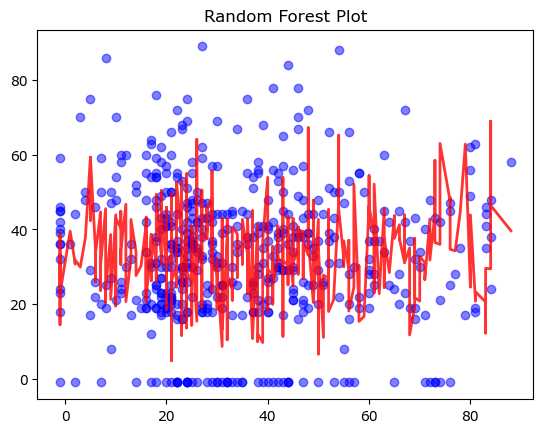

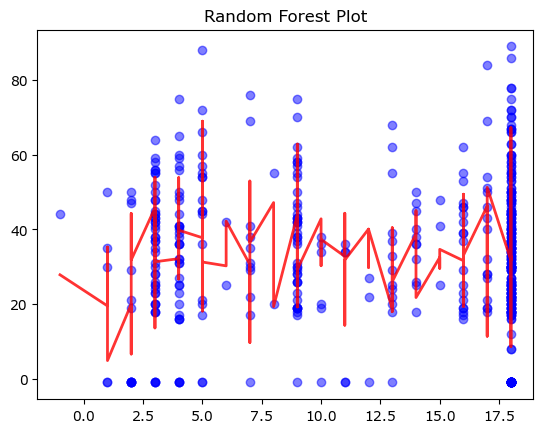

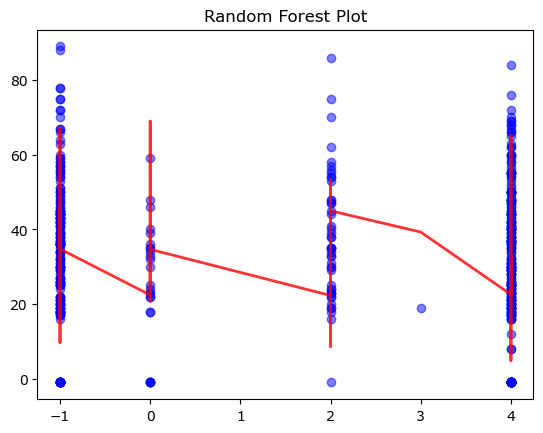

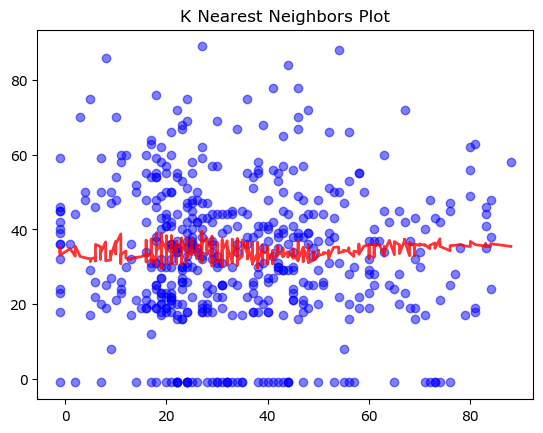

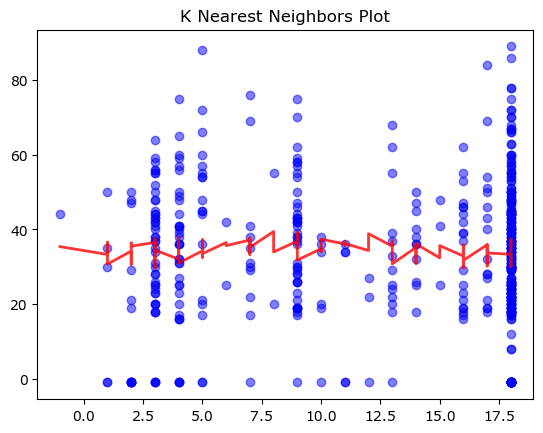

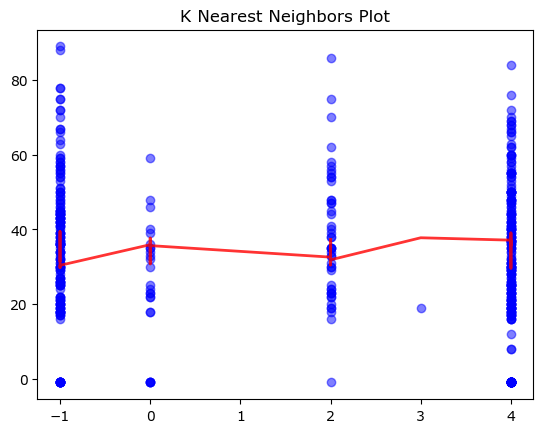

['Age_of_Casualty' 'Vehicle_Manoeuvre' 'Junction_Control' 'Age_of_Driver']
[0.60452494 0.24364737 0.15182769]
['Vehicle_Manoeuvre']
[0.60452494]


In [13]:
run_regression_models(3, "combination", ["Vehicle_Manoeuvre", "Carriageway_Hazards", "Junction_Control", "Age_of_Casualty", "Accident_Severity", "Casualty_Severity", "Pedestrian_Location", "Pedestrian_Movement", "Age_of_Driver"], 0.001)